# Computer Vision Project : Enhancing Nucleus Segmentation and 3D Reconstruction Using Super-Resolution


## Group Members:
### Rita Sulaiman – Student ID: 2210765051
### Zeynep Yıldız – Student ID: 2210765033
### Zharasbek Bimagambetov – Student ID: 2210356185


## **Load & Preprocess the Dataset**

### Imports

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import cv2
import numpy as np
import matplotlib.pyplot as plt


import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torch.nn.functional as F
import cv2

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


### Preprocessing and Image Display

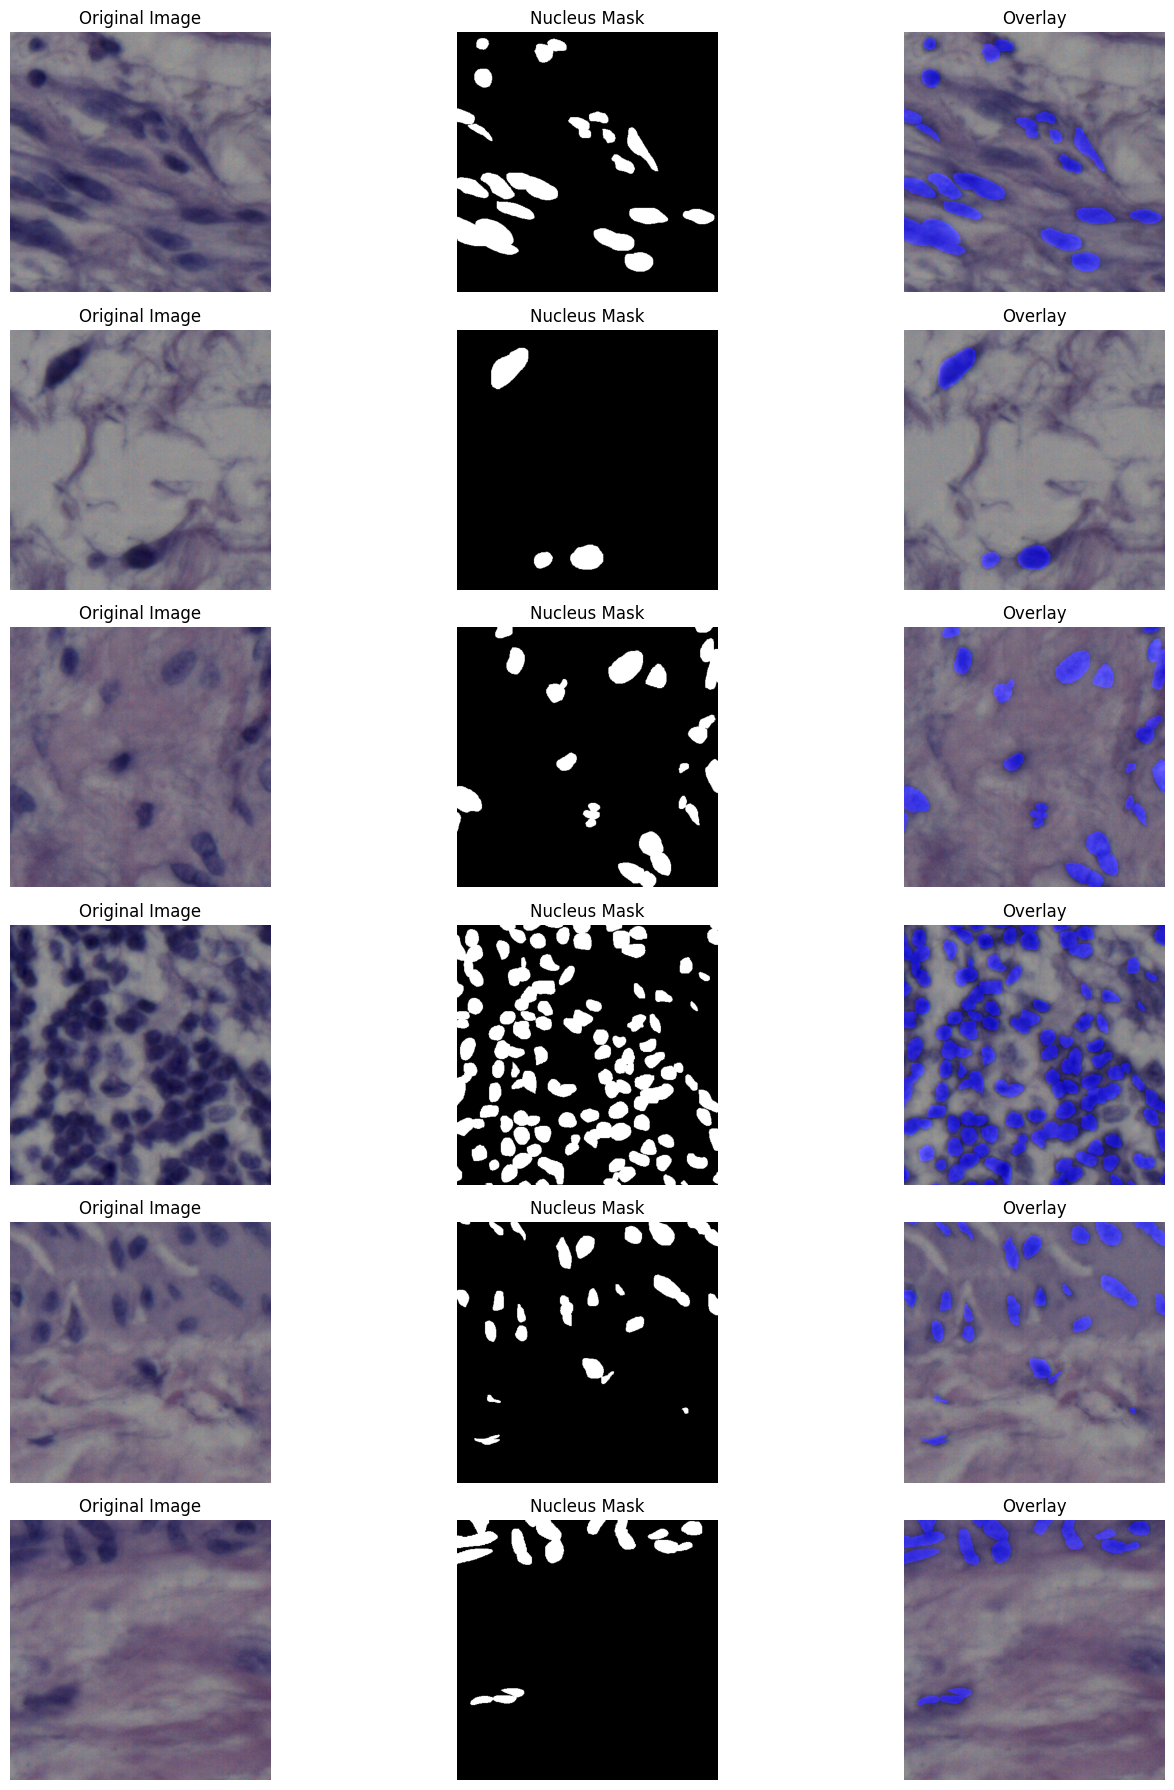

 Preprocessing complete
X shape: (12, 256, 256, 3)
Y shape: (12, 256, 256, 1)


In [2]:
# ================================
#  CONFIGURATION
# ================================

# Set base dataset directory (adjust if needed)
BASE_DIR = "."  # or use full path if notebook is outside the dataset folder
IMAGE_DIR = os.path.join(BASE_DIR, "tissue images")
MASK_DIR = os.path.join(BASE_DIR, "mask binary")  # or "label masks"

# Image size for model input
TARGET_SIZE = (256, 256)

# ================================
#  PREPROCESSING FUNCTIONS
# ================================

def preprocess_image(image, target_size):
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return image

def preprocess_mask(mask, target_size):
    mask = cv2.resize(mask, target_size)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    mask = mask.astype(np.float32) / 255.0
    mask = np.expand_dims(mask, axis=-1)  # Shape: (H, W, 1)
    return mask

# ================================
#  LOAD, DISPLAY, AND PREPROCESS
# ================================

image_files = sorted(os.listdir(IMAGE_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

X = []  # Preprocessed images
Y = []  # Preprocessed masks

num_samples = min(6, len(image_files))  # For visualization
fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))

for i in range(len(image_files)):
    img_path = os.path.join(IMAGE_DIR, image_files[i])
    mask_path = os.path.join(MASK_DIR, mask_files[i])

    #  Load original image and grayscale mask
    image_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    #  Convert to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    #  Display-only section
    if i < num_samples:
        overlay = image_rgb.copy()
        color_mask = np.zeros_like(image_rgb)
        color_mask[:, :, 2] = mask_gray  # red channel
        overlay = cv2.addWeighted(image_rgb, 1, color_mask, 0.5, 0)

        axes[i, 0].imshow(image_rgb)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask_gray, cmap="gray")
        axes[i, 1].set_title("Nucleus Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis("off")

    #  Preprocess and store for training
    image = preprocess_image(image_rgb, TARGET_SIZE)
    mask = preprocess_mask(mask_gray, TARGET_SIZE)

    X.append(image)
    Y.append(mask)

plt.tight_layout()
plt.show()

# Convert lists to arrays
X = np.array(X)
Y = np.array(Y)

print(" Preprocessing complete")
print("X shape:", X.shape)
print("Y shape:", Y.shape)



### Downsampling

In [3]:
# Input and output folder paths
input_folder = "all tissue img"          # Folder with original images
output_folder = "downsampled_images"   # Folder to save downsampled images

# Downscale factor (e.g., 0.5 = reduce size by half)
scale_factor = 0.5

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Supported image file extensions
supported_extensions = [".png", ".jpg", ".jpeg", ".tif", ".tiff"]

# Iterate through all files in the input folder
for filename in os.listdir(input_folder):
    if any(filename.lower().endswith(ext) for ext in supported_extensions):
        # Open image
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)

        # Calculate new size
        new_size = (
            int(img.width * scale_factor),
            int(img.height * scale_factor)
        )

        # Resize the image
        resized_img = img.resize(new_size, resample=Image.BICUBIC)

        # Save resized image to output folder
        output_path = os.path.join(output_folder, filename)
        resized_img.save(output_path)

        print(f"{filename} resized to → {new_size}")


human_bladder_01.png resized to → (256, 256)
human_bladder_02.png resized to → (256, 256)
human_bladder_03.png resized to → (256, 256)
human_bladder_04.png resized to → (256, 256)
human_bladder_05.png resized to → (256, 256)
human_bladder_06.png resized to → (256, 256)
human_bladder_07.png resized to → (256, 256)
human_bladder_08.png resized to → (256, 256)
human_bladder_09.png resized to → (256, 256)
human_bladder_10.png resized to → (256, 256)
human_bladder_11.png resized to → (256, 256)
human_bladder_12.png resized to → (256, 256)
human_brain_1.png resized to → (256, 256)
human_brain_10.png resized to → (256, 256)
human_brain_11.png resized to → (256, 256)
human_brain_12.png resized to → (256, 256)
human_brain_2.png resized to → (256, 256)
human_brain_3.png resized to → (256, 256)
human_brain_4.png resized to → (256, 256)
human_brain_5.png resized to → (256, 256)
human_brain_6.png resized to → (256, 256)
human_brain_7.png resized to → (256, 256)
human_brain_8.png resized to → (256, 

## **Super Resolution**

In [45]:
import torch
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np
import cv2
from tqdm import tqdm

# ========== CONFIG ==========
downsampled_folder = "downsampled_images"
original_folder = "all tissue img"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to models
model_paths = {
    "srcnn": "models/srcnn_model.pth",
    "espcn": "models/espcn_x2_256to512.pth",
    "edsr_me": "models/edsr_x2_256to512.pth",
    "edsr":"models/EDSR_x2.pb"
}

# Output dictionary to store results
results = {}


In [46]:
# Define SRCNN
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.model(x)


# Define SRDFN
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return out + residual  # Skip connection

class EDSR(nn.Module):
    def __init__(self, scale_factor=2, num_channels=64, num_blocks=8):
        super(EDSR, self).__init__()
        self.entry = nn.Conv2d(3, num_channels, kernel_size=3, padding=1)

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_channels) for _ in range(num_blocks)]
        )

        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.upsample = nn.Sequential(
            nn.Conv2d(num_channels, 3 * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor)
        )

    def forward(self, x):
        x = self.entry(x)
        res = self.res_blocks(x)
        x = self.conv(res) + x  # Global skip connection
        x = self.upsample(x)
        return x
    

# Define ESPCN
class ESPCN(nn.Module):
    def __init__(self, scale_factor=3):
        super(ESPCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3 * (scale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.pixel_shuffle(x)
        return x



In [ ]:
def apply_sr(model_name, img_path):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)

    # Directly load whole model object
    model = torch.load(model_paths[model_name], map_location=device)
    model.eval()

    with torch.no_grad():
        sr = model(input_tensor)

    sr_img = sr.squeeze(0).permute(1, 2, 0).cpu().numpy()
    return np.clip(sr_img, 0, 1)



In [52]:
model_names = ["srcnn", "espcn", "edsr_me"]

for model_name in model_names:
    psnrs = []
    ssims = []

    print(f"🔍 Testing {model_name.upper()}...")

    for filename in tqdm(os.listdir(downsampled_folder)):
        lr_path = os.path.join(downsampled_folder, filename)
        hr_path = os.path.join(original_folder, filename)

        if not os.path.exists(hr_path):
            continue

        # Load images
        lr_img = Image.open(lr_path).convert("RGB")
        hr_img = Image.open(hr_path).convert("RGB")

        # Apply super-resolution
        
        sr_img = apply_sr(model_name, lr_path)

        # Resize to match HR image
        sr_img_resized = np.array(Image.fromarray((sr_img * 255).astype(np.uint8)).resize(hr_img.size)).astype(np.float32) / 255.0
        hr_np = np.array(hr_img).astype(np.float32) / 255.0

        # Metrics
        psnr = peak_signal_noise_ratio(hr_np, sr_img_resized, data_range=1.0)
        ssim = structural_similarity(hr_np, sr_img_resized, channel_axis=-1, data_range=1.0)
        psnrs.append(psnr)
        ssims.append(ssim)

    results[model_name] = {
        "PSNR": np.mean(psnrs),
        "SSIM": np.mean(ssims)
    }

    print(f"✅ {model_name.upper()} — PSNR: {np.mean(psnrs):.2f} | SSIM: {np.mean(ssims):.4f}")


🔍 Testing SRCNN...


  0%|          | 0/665 [00:00<?, ?it/s]C:\Users\rita\AppData\Local\Temp\ipykernel_8728\2378438634.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(mode

✅ SRCNN — PSNR: 33.04 | SSIM: 0.7932
🔍 Testing ESPCN...


100%|██████████| 665/665 [00:58<00:00, 11.37it/s]


✅ ESPCN — PSNR: 35.74 | SSIM: 0.8519
🔍 Testing EDSR_ME...


100%|██████████| 665/665 [01:18<00:00,  8.44it/s]

✅ EDSR_ME — PSNR: 36.25 | SSIM: 0.8673


In [53]:
print("\n📊 Final Comparison:")
for name, metrics in results.items():
    print(f"{name.upper():<10} | PSNR: {metrics['PSNR']:.2f} | SSIM: {metrics['SSIM']:.4f}")



📊 Final Comparison:
SRCNN      | PSNR: 33.04 | SSIM: 0.7932
ESPCN      | PSNR: 35.74 | SSIM: 0.8519
EDSR_ME    | PSNR: 36.25 | SSIM: 0.8673
